# CDO DATA exploration

[Climate Data Online Search](https://www.ncdc.noaa.gov/cdo-web/search)

[GHCN (Global Historical Climatology Network) – Daily Documentation](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf)

[Go Code in Jupyter Notebook](https://github.com/janpfeifer/gonb/blob/main/examples/tutorial.ipynb)

This is a function to read CSV records from a file, caches the records, and prints the first record.

- "gonum.org/v1/plot": Offers plotting and visualization capabilities.
- "gonum.org/v1/plot/plotter": Provides plotter types for creating different types of plots.
- "gonum.org/v1/plot/vg": Defines the vector graphics (vg) package for plot rendering.

The code declares a variable csv_records using the cache.Cache function. It initializes the cache with a key "csv_records" and a function literal that calls the get_csv_records function to fetch the CSV records from the file "../csv-sample/telaviv.csv". This initialization is performed only once, and subsequent access to csv_records will retrieve the cached value. 

You can use csv_records in other cells of this file

In [40]:
import (
	"encoding/csv"
	"fmt"
	"gonum.org/v1/plot"
	"gonum.org/v1/plot/plotter"
	"gonum.org/v1/plot/vg"
	"image/color"
	"os"
	"github.com/janpfeifer/gonb/gonbui"
)

func get_csv_records(filename string) [][]string{

	// Open the CSV file
	file, err := os.Open(filename)
	if err != nil {
		panic(err)
	}
	defer file.Close()

	// Read the CSV file
	reader := csv.NewReader(file)
	records, err := reader.ReadAll()
	if err != nil {
		panic(err)
	}

	// Skip header
	records = records[1:]
	return records
}

var (
    csv_records = cache.Cache("csv_records", func() [][]string { return get_csv_records("../csv-sample/telaviv.csv") })
)

%%
fmt.Println("get_csv_records")
fmt.Println(csv_records[0])

get_csv_records
[IS000002011 TEL AVIV READING, IS 32.1 34.7831 3.0 1940-01-01   ]


This code will reset the value associated with the `csv_records` key, so next execution it will be generated again.

[Cache documentation](https://pkg.go.dev/github.com/janpfeifer/gonb/cache#hdr-A_few_considerations_to_keep_in_mind)

In [37]:
%%
cache.ResetKey("csv_records")

The next code defines a struct to hold station data, a function to count missing data for each station, caches the result using the cache.Cache function, and prints the count of missing data for each station.

So if there is "" instead of the value, this value counts as missing

The StationData struct is defined with the following fields:

Name: Represents the name of a station.
- TAVGMissing: Indicates the count of missing TAVG values for the station.
- TMAXMissing: Indicates the count of missing TMAX values for the station.
- TMINMissing: Indicates the count of missing TMIN values for the station.

The code declares a variable stations_counts using the cache.Cache function. It initializes the cache with a key "stations_counts" and a function literal that calls the count_missing_data function, passing the csv_records as input. This initialization is performed only once, and subsequent access to stations_counts will retrieve the cached value.

In [41]:
type StationData struct {
	Name        string
	TAVGMissing int
	TMAXMissing int
	TMINMissing int
}

func count_missing_data(data [][]string) []StationData {
	
	stationMap := make(map[string]*StationData)
	
	for _, record := range data {
		name := record[0]
		data, ok := stationMap[name]
		if !ok {
			data = &StationData{Name: name}
			stationMap[name] = data
		}

		// Count missing TAVG, TMAX, TMIN values
		if record[6] == "" {
			data.TAVGMissing++
		}
		if record[7] == "" {
			data.TMAXMissing++
		}
		if record[8] == "" {
			data.TMINMissing++
		}
	}

	// Convert stationMap to slice for ordered iteration
	stations := make([]StationData, 0, len(stationMap))
	
	for _, data := range stationMap {
		stations = append(stations, *data)
	}
	
	return stations
}
var (
    stations_counts = cache.Cache("stations_counts", func() []StationData { return count_missing_data(csv_records) })
)

%%
fmt.Println(stations_counts)

[{ISE00100468 3521 198 201} {IS000002011 3560 45 45} {ISE00105694 6478 96 375} {ISM00040180 0 2202 4735}]


This code generates a bar chart visualizing the missing data counts for different temperature variables (TAVG, TMAX, TMIN) across multiple stations.

The WriteTo method is called on the writerTo object, writing the plot image to the buf buffer.

Finally, the DisplayPNG function from the gonbui package is called with the buf.Bytes() to display the resulting PNG image.

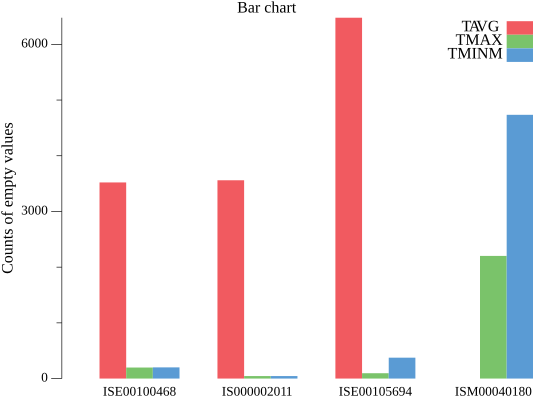

In [42]:
%%
	groupA := make(plotter.Values, len(stations_counts))
	groupB := make(plotter.Values, len(stations_counts))
	groupC := make(plotter.Values, len(stations_counts))

	for i, station := range stations_counts {
		groupA[i] = float64(station.TAVGMissing)
		groupB[i] = float64(station.TMAXMissing)
		groupC[i] = float64(station.TMINMissing)
	}

	stationNames := make([]string, len(stations_counts))

	for i, station := range stations_counts {
		stationNames[i] = station.Name
	}

	p := plot.New()

	p.Title.Text = "Bar chart"
	p.Y.Label.Text = "Counts of empty values"

	w := vg.Points(20)

	barsA, err := plotter.NewBarChart(groupA, w)
	if err != nil {
		panic(err)
	}
	barsA.LineStyle.Width = vg.Length(0)
	barsA.Color = plotutil.Color(0)
	barsA.Offset = -w

	barsB, err := plotter.NewBarChart(groupB, w)
	if err != nil {
		panic(err)
	}
	barsB.LineStyle.Width = vg.Length(0)
	barsB.Color = plotutil.Color(1)

	barsC, err := plotter.NewBarChart(groupC, w)
	if err != nil {
		panic(err)
	}
	barsC.LineStyle.Width = vg.Length(0)
	barsC.Color = plotutil.Color(2)
	barsC.Offset = w

	p.Add(barsA, barsB, barsC)
	p.Legend.Add("TAVG", barsA)
	p.Legend.Add("TMAX", barsB)
	p.Legend.Add("TMINM", barsC)
	p.Legend.Top = true
	p.NominalX(stationNames...)

	buf := bytes.NewBuffer(nil)
    writerTo, err := p.WriterTo(vg.Points(float64(400)), vg.Points(float64(300)), "png")
    if err != nil {
        panic(err)
    }
    writerTo.WriteTo(buf)
    gonbui.DisplayPNG(buf.Bytes())


In summary, this code processes data from csv_records, calculates percentages of missing values for each station and year per 366 days, and writes the results to a CSV file named "output.csv".

The code iterates over the csv_records (presumably obtained from a CSV file) and performs the following steps:

- Extracts the station name from the first column of the record.
- Parses the year from the sixth column of the record.
- Sets tavg, tmax, and tmin to 1 initially, representing the presence of those values.
- Checks if any of the TAVG, TMAX, or TMIN columns are empty. If so, it sets the corresponding variable to 0, representing a missing value.
- Adds the station and year to stationsData if they don't exist.
- Updates the StationYearData struct for the station and year by incrementing the respective count fields and total.

For each year in years, it creates a row and fills it with data. If data is available for a specific station and year, the TAVG, TMAX, and TMIN values are converted to percentages (rounded to two decimal places) based on the assumption of 366 days in a year. If data is missing, the "NA" string is used. The row is then written to the CSV file.

In [39]:
import (
	"encoding/csv"
	"fmt"
	"os"
	"sort"
	"strconv"
	"strings"
)

type StationYearData struct {
	TAVG  int
	TMAX  int
	TMIN  int
	Total int
}

%%

	stationsData := make(map[string]map[int]*StationYearData)

	for _, row := range csv_records {

		station := row[0]
		year, _ := strconv.Atoi(row[5][:4])
		tavg := 1
		tmax := 1
		tmin := 1

		if row[6] == "" {
			tavg = 0
		}
		if row[7] == "" {
			tmax = 0
		}
		if row[8] == "" {
			tmin = 0
		}

		if _, ok := stationsData[station]; !ok {
			stationsData[station] = make(map[int]*StationYearData)
		}

		if _, ok := stationsData[station][year]; !ok {
			stationsData[station][year] = &StationYearData{}
		}

		stationsData[station][year].TAVG += tavg
		stationsData[station][year].TMAX += tmax
		stationsData[station][year].TMIN += tmin
		stationsData[station][year].Total++
	}

	// Find all years and stations
	var years []int
	yearSet := make(map[int]bool)
	stations := make([]string, 0, len(stationsData))

	for station, yearDataMap := range stationsData {
		stations = append(stations, station)

		for year := range yearDataMap {
			if !yearSet[year] {
				years = append(years, year)
				yearSet[year] = true
			}
		}
	}

	sort.Strings(stations)
	sort.Ints(years)

	// Open a new file for writing
	fileOut, _ := os.Create("output.csv")
	defer fileOut.Close()

	// Create a new CSV writer writing to the file
	writer := csv.NewWriter(fileOut)
	defer writer.Flush()

	// Write the headers
	headers := []string{"Year"}
	for _, station := range stations {
		headers = append(headers, fmt.Sprintf("%s_TAVG%%", station), fmt.Sprintf("%s_TMAX%%", station), fmt.Sprintf("%s_TMIN%%", station))
	}
	writer.Write(headers)

	// Write the data
	for _, year := range years {
		row := make([]string, 1+len(stations)*3)
		row[0] = strconv.Itoa(year)

		for i, station := range stations {
			data, ok := stationsData[station][year]
			if ok {
				row[1+i*3] = fmt.Sprintf("%.2f", math.Round(float64(data.TAVG)/float64(366)*100))
				row[2+i*3] = fmt.Sprintf("%.2f", math.Round(float64(data.TMAX)/float64(366)*100))
				row[3+i*3] = fmt.Sprintf("%.2f", math.Round(float64(data.TMIN)/float64(366)*100))
			} else {
				row[1+i*3] = "NA"
				row[2+i*3] = "NA"
				row[3+i*3] = "NA"
			}
		}

		writer.Write(row)
	}

